In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)

import re
import sys

import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt #przydatna biblioteka do wizualizacji

from sklearn.dummy import DummyRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
import xgboost as xgb

from sklearn.model_selection import train_test_split

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold

from functools import partial
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials

from ml_metrics import rmsle

from sklearn.metrics import mean_absolute_error

In [ ]:
train = pd.read_hdf('../input/property.train.h5')
test = pd.read_hdf('../input/property.test.h5') #zbiór testowy bez odpowiedzi

In [ ]:
print(train.shape)
print(test.shape)
train['id'] = 0
print(train['id'].dtypes)
print(test['id'].dtypes)

**Data transformations - Feature engineering**

In [ ]:
#NOT DELETING ANY COLUMNS

#check columns with high share of missing values
cols_to_delete = []

for col in train.columns:
    print(col, train[col].isna().sum()/train[col].size)
    if train[col].isna().sum()/train[col].size > 0.99 and col != id:
        cols_to_delete.append(col)
        
print(cols_to_delete)

#train.drop(columns = cols_to_delete, inplace = True)
#test.drop(columns = cols_to_delete, inplace = True)

In [ ]:
# FILL IN MISSING VALUES WITH -1

train = train.fillna(-1)
test = test.fillna(-1)

In [ ]:
# CREATE FACTORIZE VARIABLES

train_test = pd.concat([test, train])
print(train.shape)
print(test.shape)

#factorize

cat_feats = train_test.select_dtypes(include=[np.object]).columns

for cat_feat in cat_feats:
    if cat_feat not in ['breadcrumbs','date','geo_block','owner','date_added','incremental_views','updated']:
        print(cat_feat)
        train_test['Cat_{0}'.format(cat_feat)] = pd.factorize( train_test[cat_feat] )[0]
        
train = train_test[~train_test['price'].isna()]
test = train_test[train_test['price'].isna()]

print(train.shape)
print(test.shape)

In [ ]:
# check unique values

for col in train.select_dtypes('object').columns:
    if col != 'date':
        print(f'Column: {col} number of unique values: {train[col].value_counts().size}')
        print(train[col].value_counts())
        print("")

In [ ]:
# extract some variables from date column = TEST

train[['date_added','views','incremental_views','updated']] = pd.DataFrame(train['date'].tolist())

# not all elements of the list are always present, here omitting one of them:
train.loc[train['incremental_views'].str.contains('Обновлено', na=False),'updated'] = train['incremental_views']
train.loc[train['incremental_views'].str.contains('Обновлено', na=False),'incremental_views'] = -1

train['views'] = train['views'].apply(lambda x: int(x))

#------------------------------------------------------------------------------------

# extract some variables from date column = TEST

test[['date_added','views','incremental_views','updated']] = pd.DataFrame(test['date'].tolist())

# not all elements of the list are always present, here omitting one of them:
test.loc[test['incremental_views'].str.contains('Обновлено', na=False),'updated'] = test['incremental_views']
test.loc[test['incremental_views'].str.contains('Обновлено', na=False),'incremental_views'] = -1

test['views'] = test['views'].apply(lambda x: int(x))

In [ ]:
# replace incremental views with 1,2,3 and 99 for other

from collections import defaultdict
pd.options.display.max_columns = None
train.head()

top_titles = list(train['incremental_views'].value_counts().head(3).keys())
print(top_titles)

title_norm = defaultdict(lambda: 99, dict(zip(top_titles, [1,2,3])))
print(title_norm)

train['incremental_views_o'] = train['incremental_views'].map(title_norm)
test['incremental_views_o'] = test['incremental_views'].map(title_norm)
train['incremental_views_o'].value_counts()

In [ ]:
# CREATE DATE RELATED VARIABLES

def days(day):
    if day != 'вчера' and day != 'сегодня':
        return int(day)
    else:
        return 19 # 19th of May to be exact, because I believe that will be around the last day of the data

def months(month):
    if month=='мая': return 5
    if month=='апреля': return 4
    if month=='марта': return 3
    if month=='февраля': return 2
    if month=='января': return 1
    if month=='октября': return 10
    if month=='декабря': return 12
    if month=='ноября': return 11
    if month=='сентября': return 9
    if month=='августа': return 8
    if month=='июля': return 7
    if month=='июня': return 6
    if month=='в': return 5 # I assume that May is the most recent month
    
def years(year):
    if year=='2017': return 2017
    elif year=='2018': return 2018
    else: return 2019     
    
#------------------------------------------------------------------------------------

train['day'] = train.date_added.str.split(' ', expand = True)[0].apply(lambda x: int(days(x)))
train['month'] = train.date_added.str.split(' ', expand = True)[1].apply(lambda x: int(months(x)))
train['freshly_added'] = train.date_added.str.split(' ', expand = True)[1] == 'в'
train['year'] = train.date_added.str.split(' ', expand = True)[2].apply(lambda x: int(years(x)))

train['views'] = train.views.apply(lambda x: int(x))
train['flg_updated'] = ~train['updated'].isna()

#------------------------------------------------------------------------------------

test['day'] = test.date_added.str.split(' ', expand = True)[0].apply(lambda x: days(x))
test['month'] = test.date_added.str.split(' ', expand = True)[1].apply(lambda x: months(x))
test['freshly_added'] = test.date_added.str.split(' ', expand = True)[1] == 'в'
test['year'] = test.date_added.str.split(' ', expand = True)[2].apply(lambda x: years(x))

test['views'] = test.views.apply(lambda x: int(x))
test['flg_updated'] = ~test['updated'].isna()

In [ ]:
# create variables based on date of the ad

import datetime

a = pd.Timestamp('2019-05-19') # I treat this as the last day of the data, there are also some outliers which I neglect

train['date_added_d'] = pd.to_datetime(train[['year','month','day']])
train['days_since_added'] = abs(train['date_added_d'] - a).astype('timedelta64[D]')
train['months_since_added'] = abs(train['date_added_d'] - a).astype('timedelta64[D]')/30

test['date_added_d'] = pd.to_datetime(test[['year','month','day']])
test['days_since_added'] = abs(test['date_added_d'] - a).astype('timedelta64[D]')
test['months_since_added'] = abs(test['date_added_d'] - a).astype('timedelta64[D]')/30

train.groupby('date_added_d')['price'].size().plot()
plt.show()

train.groupby('date_added_d')['price'].mean().plot()
plt.show()

In [ ]:
# taken from Vladimir's code
# change price variable to log to limit skewness

train['price_log'] = np.log( train['price'] )

plt.figure(figsize=(500,20))
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4,2, figsize=(15, 20))
fig.subplots_adjust(hspace=.8)

def sub_plot(data, column, ax1, ax2):
    data.hist(column, bins=30, ax=ax1)
    data.boxplot(column, ax=ax2)

sub_plot(train, 'price', ax1, ax2)
sub_plot(train[ train.price < np.percentile( train.price, 99 ) ], 'price', ax3, ax4)
sub_plot(train, 'price_log', ax5, ax6)
sub_plot(train[ (train.price_log > np.percentile( train.price_log, 1 )) & (train.price_log < np.percentile( train.price_log, 99 )) ], 'price_log', ax7, ax8)

In [ ]:
# replace rare values with 'other', then create dummies

#------------------------------------------------------------------------------------
#Column: Building type

#change too many values into 'other' before get dummies
cnt_values = train_test['Building type:'].value_counts().reset_index()
other_vals = set(cnt_values[ cnt_values['Building type:'] < 500 ]['index'].values)

train['Building_type_other'] = train['Building type:'].map(lambda x: 'other' if x in other_vals else x)
test['Building_type_other'] = test['Building type:'].map(lambda x: 'other' if x in other_vals else x)

sns.barplot(x="Building_type_other", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);

#get dummies
df_ohe = pd.get_dummies(train['Building_type_other'], prefix='Dum_bld_typ')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Building_type_other'], prefix='Dum_bld_typ')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Object type

sns.barplot(x="Object type:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Object type:'], prefix='Dum_obj_typ')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Object type:'], prefix='Dum_obj_typ')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Ad type

sns.barplot(x="Ad type:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Ad type:'], prefix='Dum_ad_typ')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Ad type:'], prefix='Dum_ad_typ')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Commission agent - blacklisted

sns.barplot(x="Commission agent:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#black_list = black_list.append('Commission agent:')



#------------------------------------------------------------------------------------
#Column: Construction phase

sns.barplot(x="Construction phase:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Construction phase:'], prefix='Dum_con_pha')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Construction phase:'], prefix='Dum_con_pha')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Housing class

sns.barplot(x="Housing class:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Housing class:'], prefix='Dum_hou_cla')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Housing class:'], prefix='Dum_hou_cla')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Bathroom type

sns.barplot(x="Bathroom type:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Bathroom type:'], prefix='Dum_bat_typ')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Bathroom type:'], prefix='Dum_bat_typ')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Balcony type

cnt_values = train_test['Balcony type:'].value_counts().reset_index()
other_vals = set(cnt_values[ cnt_values['Balcony type:'] < 500 ]['index'].values)
train['Balcony_type_other'] = train['Balcony type:'].map(lambda x: 'other' if x in other_vals else x)
test['Balcony_type_other'] = test['Balcony type:'].map(lambda x: 'other' if x in other_vals else x)

sns.barplot(x="Balcony_type_other", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Balcony_type_other'], prefix='Dum_bal_typ')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Balcony_type_other'], prefix='Dum_bal_typ')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: The view from the window

sns.barplot(x="The view from the window:", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['The view from the window:'], prefix='Dum_view')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['The view from the window:'], prefix='Dum_view')
test = pd.concat([test, df_ohe], axis=1)



#------------------------------------------------------------------------------------
#Column: Security

#change too many values into 'other' before get dummies
cnt_values = train_test['Security:'].value_counts().reset_index()
other_vals = set(cnt_values[ cnt_values['Security:'] < 800 ]['index'].values)
train['Security_other'] = train['Security:'].map(lambda x: 'other' if x in other_vals else x)
test['Security_other'] = test['Security:'].map(lambda x: 'other' if x in other_vals else x)

sns.barplot(x="Security_other", y="price", data=train, estimator=np.median)
plt.xticks(rotation=90);
plt.show()

#get dummies
df_ohe = pd.get_dummies(train['Security_other'], prefix='Dum_sec')
train = pd.concat([train, df_ohe], axis=1)

df_ohe = pd.get_dummies(test['Security_other'], prefix='Dum_sec')
test = pd.concat([test, df_ohe], axis=1)

In [ ]:
# boolean - if there is security at all

train['Repair_euro_flg'] = train['Repair:'] == 'euro'
train['Security_flg'] = train['Security:'] != -1

test['Repair_euro_flg'] = test['Repair:'] == 'euro'
test['Security_flg'] = test['Security:'] != -1

In [ ]:
# create variables based on Security type - not sure if this is not prone to overfitting

security_groupby = train.groupby('Security:')['price'].agg([np.mean,np.median,'size']).reset_index()
security_85 = security_groupby[security_groupby['median'] > np.percentile( train.price, 85 )]['Security:'].values
security_75 = security_groupby[security_groupby['median'] > np.percentile( train.price, 75 )]['Security:'].values
security_50 = security_groupby[security_groupby['median'] > np.percentile( train.price, 50 )]['Security:'].values

train['Security_85'] = train['Security:'].map(lambda x: x in security_85)
train['Security_75'] = train['Security:'].map(lambda x: x in security_75)
train['Security_50'] = train['Security:'].map(lambda x: x in security_50)

test['Security_85'] = test['Security:'].map(lambda x: x in security_85)
test['Security_75'] = test['Security:'].map(lambda x: x in security_75)
test['Security_50'] = test['Security:'].map(lambda x: x in security_50)

In [ ]:
pd.options.display.max_columns = None
train.head()

In [ ]:
# correlation matrix

plt.rcParams['figure.figsize']=(20,10)
sns.heatmap(train.loc[:,[col for col in train.columns if not col.startswith('Dum')]].corr(), vmax=1., vmin=-1., annot=True, linewidths=.8, cmap="YlGnBu");

In [ ]:
for delcol in ['flg_dev_noc','flg_dev_new']:
    if delcol in train.columns: train.drop(columns = delcol, inplace=True)
    
# Additional features
train['flg_flat_brick'] = (train['Building_type_other'] == 'Brick') & (train['Object type:'] == 'flat')
train['flg_apar_monbrick'] = (train['Building_type_other'] == 'Monolithic-brick') & (train['Object type:'] == 'apartments')
train['flg_flat_monbrick'] = (train['Building_type_other'] == 'Monolithic-brick') & (train['Object type:'] == 'flat')
train['flg_new_monbrick'] = (train['Building_type_other'] == 'Monolithic-brick') & (train['Ad type:'] == 'new building')
train['flg_dev_monbrick'] = (train['Building_type_other'] == 'Monolithic-brick') & (train['Ad type:'] == 'from the developer')
train['flg_monbrick_com'] = (train['Construction phase:'] == 'Commissioned') & (train['Building_type_other'] == 'Monolithic-brick')
train['flg_mon_com'] = (train['Construction phase:'] == 'Commissioned') & (train['Building_type_other'] == 'Monolithic')
train['flg_mon_ele'] = (train['Elevator:'] == 'yes') & (train['Building_type_other'] == 'Monolithic')
train['flg_ad_ele'] = (train['Elevator:'] == -1) & (train['Ad type:'] == 'new building')
train['flg_ad_bal'] = (train['Balcony type:'] == -1) & (train['Ad type:'] == 'new building')
train['flg_flat_mon'] = (train['Building_type_other'] == 'Monolithic') & (train['Object type:'] == 'flat')
train['flg_apar_new'] = (train['Ad type:'] == 'new building') & (train['Object type:'] == 'apartments')
train['flg_flat_new'] = (train['Ad type:'] == 'new building') & (train['Object type:'] == 'flat')
train['flg_flat_com'] = (train['Construction phase:'] == 'Commissioned') & (train['Object type:'] == 'flat')
train['flg_flat_pro'] = (train['Construction phase:'] == 'Project') & (train['Object type:'] == 'flat')
train['flg_elev_con'] = ((train['Construction phase:']=='Building walls') | (train['Construction phase:']=='Finish') | (train['Construction phase:']=='Playground')) & (train['Elevator:'] == 'yes')
train['flg_ad_com'] = (train['Construction phase:'] == 'Commissioned') & (train['Ad type:'] == 'new building')
train['flg_ad_bus'] = (train['Housing class:'] == 'Business class') & (train['Ad type:'] == 'new building')
train['flg_ad_eli'] = (train['Housing class:'] == 'Elite class') & (train['Ad type:'] == 'new building')
train['flg_ad_mor'] = (train['Mortgage possible:'] == -1) & (train['Ad type:'] == 'new building')
train['flg_ad_mor2'] = (train['Mortgage possible:'] == 'yes') & (train['Ad type:'] == 'new building')
train['flg_flat_con'] = ((train['Construction phase:']=='Building walls') | (train['Construction phase:']=='Finish')) & (train['Object type:'] == 'flat')
train['flg_apar_gar'] = (train['Garbage chute:'] == -1) & (train['Object type:'] == 'apartments')
train['flg_apar_com'] = (train['Construction phase:'] == 'Commissioned') & (train['Object type:'] == 'apartments')
train['flg_flat_ele'] = (train['Elevator:'] == 'yes') & (train['Object type:'] == 'flat')
train['flg_apar_ele'] = (train['Elevator:'] == 'yes') & (train['Object type:'] == 'apartments')
train['flg_flat_sep'] = (train['Bathroom type:'] == 'separate') & (train['Object type:'] == 'flat')
train['flg_flat_log'] = (train['Balcony_type_other'] == 'loggia') & (train['Object type:'] == 'flat')
train['flg_flat_-1'] = (train['Balcony_type_other'] == -1) & (train['Object type:'] == 'flat')
train['flg_flat_mor'] = (train['Mortgage possible:'] == -1) & (train['Object type:'] == 'flat')
train['flg_apar_bath'] = ((train['Bathroom type:']=='combined') | (train['Bathroom type:']=='separate')) & (train['Object type:'] == 'apartments')
train['flg_mon_mor'] = (train['Mortgage possible:'] == 'yes') & (train['Building_type_other'] == 'Monolithic')
train['flg_mon_view'] = (train['The view from the window:'] == -1) & (train['Building_type_other'] == 'Monolithic')
train['flg_street_flat'] = (train['The view from the window:'] == 'street') & (train['Object type:'] == 'flat')
train['flg_yard_flat'] = (train['The view from the window:'] == 'yard') & (train['Object type:'] == 'flat')
train['flg_eli_new'] = (train['Housing class:'] == 'Elite class') & (train['Ad type:'] == 'new building')

for col in train.columns:
    if col.startswith('flg'):
        print(f'column "{col}" occurences: {train[col].sum()}')        

In [ ]:
#same for test
for delcol in ['flg_dev_noc','flg_dev_new']:
    if delcol in test.columns: test.drop(columns = delcol, inplace=True)
    
# Additional features
test['flg_flat_brick'] = (test['Building_type_other'] == 'Brick') & (test['Object type:'] == 'flat')
test['flg_apar_monbrick'] = (test['Building_type_other'] == 'Monolithic-brick') & (test['Object type:'] == 'apartments')
test['flg_flat_monbrick'] = (test['Building_type_other'] == 'Monolithic-brick') & (test['Object type:'] == 'flat')
test['flg_new_monbrick'] = (test['Building_type_other'] == 'Monolithic-brick') & (test['Ad type:'] == 'new building')
test['flg_dev_monbrick'] = (test['Building_type_other'] == 'Monolithic-brick') & (test['Ad type:'] == 'from the developer')
test['flg_monbrick_com'] = (test['Construction phase:'] == 'Commissioned') & (test['Building_type_other'] == 'Monolithic-brick')
test['flg_mon_com'] = (test['Construction phase:'] == 'Commissioned') & (test['Building_type_other'] == 'Monolithic')
test['flg_mon_ele'] = (test['Elevator:'] == 'yes') & (test['Building_type_other'] == 'Monolithic')
test['flg_ad_ele'] = (test['Elevator:'] == -1) & (test['Ad type:'] == 'new building')
test['flg_ad_bal'] = (test['Balcony type:'] == -1) & (test['Ad type:'] == 'new building')
test['flg_flat_mon'] = (test['Building_type_other'] == 'Monolithic') & (test['Object type:'] == 'flat')
test['flg_apar_new'] = (test['Ad type:'] == 'new building') & (test['Object type:'] == 'apartments')
test['flg_flat_new'] = (test['Ad type:'] == 'new building') & (test['Object type:'] == 'flat')
test['flg_flat_com'] = (test['Construction phase:'] == 'Commissioned') & (test['Object type:'] == 'flat')
test['flg_flat_pro'] = (test['Construction phase:'] == 'Project') & (test['Object type:'] == 'flat')
test['flg_elev_con'] = ((test['Construction phase:']=='Building walls') | (test['Construction phase:']=='Finish') | (test['Construction phase:']=='Playground')) & (test['Elevator:'] == 'yes')
test['flg_ad_com'] = (test['Construction phase:'] == 'Commissioned') & (test['Ad type:'] == 'new building')
test['flg_ad_bus'] = (test['Housing class:'] == 'Business class') & (test['Ad type:'] == 'new building')
test['flg_ad_eli'] = (test['Housing class:'] == 'Elite class') & (test['Ad type:'] == 'new building')
test['flg_ad_mor'] = (test['Mortgage possible:'] == -1) & (test['Ad type:'] == 'new building')
test['flg_ad_mor2'] = (test['Mortgage possible:'] == 'yes') & (test['Ad type:'] == 'new building')
test['flg_flat_con'] = ((test['Construction phase:']=='Building walls') | (test['Construction phase:']=='Finish')) & (test['Object type:'] == 'flat')
test['flg_apar_gar'] = (test['Garbage chute:'] == -1) & (test['Object type:'] == 'apartments')
test['flg_apar_com'] = (test['Construction phase:'] == 'Commissioned') & (test['Object type:'] == 'apartments')
test['flg_flat_ele'] = (test['Elevator:'] == 'yes') & (test['Object type:'] == 'flat')
test['flg_apar_ele'] = (test['Elevator:'] == 'yes') & (test['Object type:'] == 'apartments')
test['flg_flat_sep'] = (test['Bathroom type:'] == 'separate') & (test['Object type:'] == 'flat')
test['flg_flat_log'] = (test['Balcony_type_other'] == 'loggia') & (test['Object type:'] == 'flat')
test['flg_flat_-1'] = (test['Balcony_type_other'] == -1) & (test['Object type:'] == 'flat')
test['flg_flat_mor'] = (test['Mortgage possible:'] == -1) & (test['Object type:'] == 'flat')
test['flg_apar_bath'] = ((test['Bathroom type:']=='combined') | (test['Bathroom type:']=='separate')) & (test['Object type:'] == 'apartments')
test['flg_mon_mor'] = (test['Mortgage possible:'] == 'yes') & (test['Building_type_other'] == 'Monolithic')
test['flg_mon_view'] = (test['The view from the window:'] == -1) & (test['Building_type_other'] == 'Monolithic')
test['flg_street_flat'] = (test['The view from the window:'] == 'street') & (test['Object type:'] == 'flat')
test['flg_yard_flat'] = (test['The view from the window:'] == 'yard') & (test['Object type:'] == 'flat')
test['flg_eli_new'] = (test['Housing class:'] == 'Elite class') & (test['Ad type:'] == 'new building')

for col in test.columns:
    if col.startswith('flg'):
        print(f'column "{col}" occurences: {test[col].sum()}')        

In [ ]:
#factorizing elements from Security (top X elements)

all_elements = dict()

def extract_elements(element):
    if '-1' == str(element): return
    
    for value in element.split(','):
        value = value.lower().strip()
        if '' == value: continue
            
        if value in all_elements:
            all_elements[value] += 1
        else:
            all_elements[value] =1
    
_ = train['Security:'].map(extract_elements)

print(len(all_elements))
all_elements

#creating a list of most popular geo block
sel_elements = pd.DataFrame.from_dict(all_elements, orient='index', dtype=None, columns=None).sort_values(0, ascending=False).head(10).index
pd.factorize( list(sel_elements) )

In [ ]:
train.drop(columns= [col for col in train.columns if col.startswith('security_')], inplace=True)

idx_elements, labels_elements = pd.factorize( list(sel_elements) )

for idx_element in idx_elements:
    cat_name = 'security_{0}'.format( labels_elements[idx_element].replace(' ', '_') )
    ben_label = labels_elements[idx_element]
    #print(cat_name)
    #print(ben_label)
    train[cat_name] = train['Security:'].map(lambda x: int(ben_label in x.lower()) if '-1' != str(x) else 0 )
    test[cat_name] = test['Security:'].map(lambda x: int(ben_label in x.lower()) if '-1' != str(x) else 0 )
    
for col in [col for col in train.columns if col.startswith('security_')]:
    print(train.groupby(col)['price'].agg([np.mean, np.median, 'size']))

In [ ]:
#factorizing elements from list: geo_block (top 10 elements)

all_elements = dict()

def extract_elements(element):
    if 'nan' == str(element): return
    
    for value in element:
        value = value.strip()
        if '' == value: continue
            
        if value in all_elements:
            all_elements[value] += 1
        else:
            all_elements[value] =1
    
_ = train['geo_block'].map(extract_elements)

print(len(all_elements))
all_elements

#creating a list of most popular geo block
sel_elements = pd.DataFrame.from_dict(
    all_elements, orient='index', dtype=None, columns=None).sort_values(0, ascending=False).head(100).index
pd.factorize( list(sel_elements) )

In [ ]:
train.drop(columns= [col for col in train.columns if col.startswith('geo_block_')], inplace=True)

idx_elements, labels_elements = pd.factorize( list(sel_elements) )

for idx_element in idx_elements:
    cat_name = 'geo_block_{0}'.format( labels_elements[idx_element].replace(' ', '_') )
    ben_label = labels_elements[idx_element]
    #print(cat_name)
    #print(ben_label)
    train[cat_name] = train['geo_block'].map(lambda x: int(ben_label in x) if 'nan' != str(x) else 0 )
    test[cat_name] = test['geo_block'].map(lambda x: int(ben_label in x) if 'nan' != str(x) else 0 )
    
for col in [col for col in train.columns if col.startswith('geo_block_')]:
    print(train.groupby(col)['price'].agg([np.mean, np.median, 'size']))

In [ ]:
#factorizing elements from list: breadcrumbs (top X elements)

all_elements = dict()

def extract_elements(element):
    if 'nan' == str(element): return
    
    for value in element:
        value = value.strip()
        if '' == value: continue
            
        if value in all_elements:
            all_elements[value] += 1
        else:
            all_elements[value] =1
    
_ = train['breadcrumbs'].map(extract_elements)

print(len(all_elements))
all_elements

#creating a list of most popular breadcrumbs
sel_elements = pd.DataFrame.from_dict(
    all_elements, orient='index', dtype=None, columns=None).sort_values(0, ascending=False).head(100).index
pd.factorize( list(sel_elements) )

In [ ]:
train.drop(columns= [col for col in train.columns if col.startswith('breadcrumbs_')], inplace=True)

idx_elements, labels_elements = pd.factorize( list(sel_elements) )

for idx_element in idx_elements:
    cat_name = 'breadcrumbs_{0}'.format( labels_elements[idx_element].replace(' ', '_') )
    ben_label = labels_elements[idx_element]
    #print(cat_name)
    #print(ben_label)
    train[cat_name] = train['breadcrumbs'].map(lambda x: int(ben_label in x) if 'nan' != str(x) else 0 )
    test[cat_name] = test['breadcrumbs'].map(lambda x: int(ben_label in x) if 'nan' != str(x) else 0 )
    
train['cnt_breadcrumbs'] = train[[col for col in train.columns if 'breadcrumbs_' in col]].sum(axis=1)
test['cnt_breadcrumbs'] = test[[col for col in train.columns if 'breadcrumbs_' in col]].sum(axis=1)
train['other_than_MCC'] = train[[col for col in train.columns if ('breadcrumbs_' in col and 'МЦК' not in col)]].sum(axis=1)
test['other_than_MCC'] = test[[col for col in train.columns if ('breadcrumbs_' in col and 'МЦК' not in col)]].sum(axis=1)
train['MCC_flg'] = train[[col for col in train.columns if 'МЦК' in col]].sum(axis=1)
test['MCC_flg'] = test[[col for col in train.columns if 'МЦК' in col]].sum(axis=1)
train['MCC_flg_2'] = train[['breadcrumbs_МЦК_Коптево','breadcrumbs_МЦК_Верхние_Котлы','breadcrumbs_МЦК_Дубровка','breadcrumbs_МЦК_ЗИЛ','breadcrumbs_МЦК_Крымская','breadcrumbs_МЦК_Деловой_центр']].sum(axis=1)
test['MCC_flg_2'] = test[['breadcrumbs_МЦК_Коптево','breadcrumbs_МЦК_Верхние_Котлы','breadcrumbs_МЦК_Дубровка','breadcrumbs_МЦК_ЗИЛ','breadcrumbs_МЦК_Крымская','breadcrumbs_МЦК_Деловой_центр']].sum(axis=1)
train['MCC_flg_3'] = train[['breadcrumbs_МЦК_Стрешнево','breadcrumbs_МЦК_Лихоборы','breadcrumbs_МЦК_Шелепиха','breadcrumbs_МЦК_Ростокино','breadcrumbs_МЦК_Ботанический_сад','breadcrumbs_МЦК_Окружная','breadcrumbs_МЦК_Нижегородская','breadcrumbs_МЦК_Зорге','breadcrumbs_МЦК_Соколиная_Гора','breadcrumbs_МЦК_Владыкино','breadcrumbs_МЦК_Шоссе_Энтузиастов','breadcrumbs_МЦК_Панфиловская','breadcrumbs_МЦК_Угрешская']].sum(axis=1)
test['MCC_flg_3'] = test[['breadcrumbs_МЦК_Стрешнево','breadcrumbs_МЦК_Лихоборы','breadcrumbs_МЦК_Шелепиха','breadcrumbs_МЦК_Ростокино','breadcrumbs_МЦК_Ботанический_сад','breadcrumbs_МЦК_Окружная','breadcrumbs_МЦК_Нижегородская','breadcrumbs_МЦК_Зорге','breadcrumbs_МЦК_Соколиная_Гора','breadcrumbs_МЦК_Владыкино','breadcrumbs_МЦК_Шоссе_Энтузиастов','breadcrumbs_МЦК_Панфиловская','breadcrumbs_МЦК_Угрешская']].sum(axis=1)

for col in [col for col in train.columns if col.startswith('breadcrumbs_')]:
    print(train.groupby(col)['price'].agg([np.mean, np.median, 'size']))

In [ ]:
#factorizing elements from list: breadcrumbs (METRO)

all_elements = dict()

def extract_elements(element):
    if 'nan' == str(element): return
    
    for value in element:
        value = value.strip()
        if 'МЦК' in value:
            if '' == value: continue

            if value in all_elements:
                all_elements[value] += 1
            else:
                all_elements[value] =1
    
_ = train['breadcrumbs'].map(extract_elements)

print(len(all_elements))
all_elements

#creating a list of most popular geo block
sel_elements = pd.DataFrame.from_dict(
    all_elements, orient='index', dtype=None, columns=None).sort_values(0, ascending=False).index
pd.factorize( list(sel_elements) )

In [ ]:
# extract metro station name

def el(x):
    for el in sel_elements:
        if el in x:
            return el.replace('МЦК ','')
    
train['metro_station'] = train['breadcrumbs'].apply(lambda x: el(x))
test['metro_station'] = test['breadcrumbs'].apply(lambda x: el(x))

In [ ]:
metro = pd.read_csv('metro.csv', parse_dates=True, sep=';')
metro = metro.fillna(0)
metro.drop(columns = 'Transfer', inplace=True)
import datetime
metro['Opened'] = pd.to_datetime(metro['Opened'])
a = pd.Timestamp('2019-05-19')
metro['metro_years'] = (abs(metro['Opened'] - a).astype('timedelta64[D]')/365).astype(int)

print(metro.tail(10))

# extract information about metro lines - each station name can relate to multiple lines

metro_lines = pd.pivot_table(data=metro, index='Russian Cyrillic', columns='L', values='Type', 
               aggfunc=lambda x: len(x.unique()),fill_value=0).add_prefix('L_')
print(metro_lines)

# extract information about number of transfer and metro availability date, also line number as integer

metro_transfers = metro.groupby('Russian Cyrillic').aggregate(
    {
        'Transfer_cnt':np.max, 
        'metro_years':np.max,
        'L':np.min
    }
)

print(metro_transfers)

# combine all metro information

metro_info = metro_lines.join(metro_transfers).reset_index().rename(columns = {'Russian Cyrillic' : 'metro_station'})
print(metro_info)

In [ ]:
# there were some trials and errors, so first I drop all columns created from metro data previously

train.drop(columns = [col for col in train.columns if (
    col.startswith('L_') or col.startswith('Transfer_cnt') or col.startswith('metro_years'))],
          inplace=True)

test.drop(columns = [col for col in test.columns if (
    col.startswith('L_') or col.startswith('Transfer_cnt') or col.startswith('metro_years'))],
          inplace=True)

# add metro information to test and train

train = train.merge(metro_info, on='metro_station', how='left')
test = test.merge(metro_info, on='metro_station', how='left')

**Save and load preprocessed data**

In [ ]:
# save test and train

#train.to_hdf('property.train_changed.h5',key='df', mode='w')
#test.to_hdf('property.test_changed.h5',key='df', mode='w') #zbiór testowy bez odpowiedzi

In [2]:
# read saved datasets

train = pd.read_hdf('property.train_changed.h5')
test = pd.read_hdf('property.test_changed.h5')

print(train.shape)
print(test.shape)

(45694, 404)
(22667, 403)


**Initial code for running and comparing models**

with learning curve and feature importance plot

In [11]:
def get_feats(df, black_list):
    feats = df.select_dtypes(exclude=[object, 'datetime' ]).columns 
    return [x for x in feats if x not in black_list]

def get_X(df, black_list):
    return df[ get_feats(df, black_list) ].values

def get_y(df, target_var='price'):
    return df[target_var].values

def run_cv(model, X, y, folds=4, target_log=False, cv_type=KFold, success_metric=mean_absolute_error):
    cv = cv_type(n_splits=folds)
    
    scores = []
    for train_idx, test_idx in cv.split(X):
        X_train, X_test = X[train_idx], X[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if target_log:
            y_train = np.log(y_train)

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = 0 #czasem może być wartość ujemna

        score = success_metric(y_test, y_pred)
        scores.append( score )
        
        print(score)
        
    return np.mean(scores), np.std(scores)


def plot_learning_curve(model, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5), target_log=False):
    
    plt.figure(figsize=(12,8))
    plt.title(title)
    if ylim is not None:plt.ylim(*ylim)

    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    if target_log:
        y = np.log(y)
    
    def my_scorer(model, X, y):
        y_pred = model.predict(X)
        
        if target_log:
            y = np.exp(y)
            y_pred = np.exp(y_pred)
            y_pred[ y_pred<0 ] = 0
        
        return mean_absolute_error(y, y_pred)

        
    train_sizes, train_scores, test_scores = learning_curve(
        model, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=my_scorer)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


def run(train, plot_lc=False, folds=3, ylim=None, target_log=False, plot_feature_importances=False, 
        black_list=['price','price_log'],
        feats_list=['MCC_flg'],
        use_black_list = False,
        use_feat_list = True):
       
    for model_name, model in get_models():
        
        if use_black_list:
            feats = get_feats(train, black_list=black_list)
            X, y  = get_X(train, black_list), get_y(train)
        if use_feat_list:
            feats = feats_list
            X, y  = train[ feats ].values, train['price'].values
        
        #print(feats)
        #print(len(feats))
        print('X.columns:{}'.format(X.shape))
        #------------------------------------------
        #-------------validation set---------------
        X, X_val, y, y_val = train_test_split(X, y, test_size=0.01, random_state=1)
        #------------------------------------------

        score_mean, score_std = run_cv(model, X, y, folds=folds, target_log=target_log)
        print("[{0}]: {1} +/-{2}".format(model_name, score_mean, score_std))
        sys.stdout.flush() #wypisujemy wynik natychmiast, bez buforowania

        if plot_lc: 
            plt = plot_learning_curve(model, model_name, X, y, ylim=ylim, cv=folds, target_log=target_log)
            plt.show()
        
        if plot_feature_importances:
            print('printing feature importances') 
            
            if target_log:
                y = np.log(y)
            model.fit(X, y)
            #------------------------------------------
            #-------------validation set---------------
            y_pred_val = model.predict(X_val)
        
            if target_log:
                y_pred_val = np.exp(y_pred_val)
                y_pred_val[y_pred_val < 0] = y_val.min() #czasem może być wartość ujemna

            score_val = mean_absolute_error(y_val, y_pred_val)
            print(f'score on validation set: {score_val} model: {model_name}')
            #------------------------------------------
            
            #xgbfir.saveXgbFI(model, feature_names=feats, OutputXlsxFile=f'{model_name}.xlsx')
            
            importances = model.feature_importances_
            indices = np.argsort(importances)[::-1]
            
            title='Feature Importance. {0}'.format(model)
            print([ feats[x] for x in indices])
            skplt.estimators.plot_feature_importances(model, feature_names=feats, title=title, x_tick_rotation=90, figsize=(15, 5));    
            

X.columns:(45694, 359)
[21:01:03] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


4.911093166945164
[21:05:28] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


5.349834841801177
[21:09:54] WARNING: /workspace/src/learner.cc:480: 
Parameters: { verbose } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this


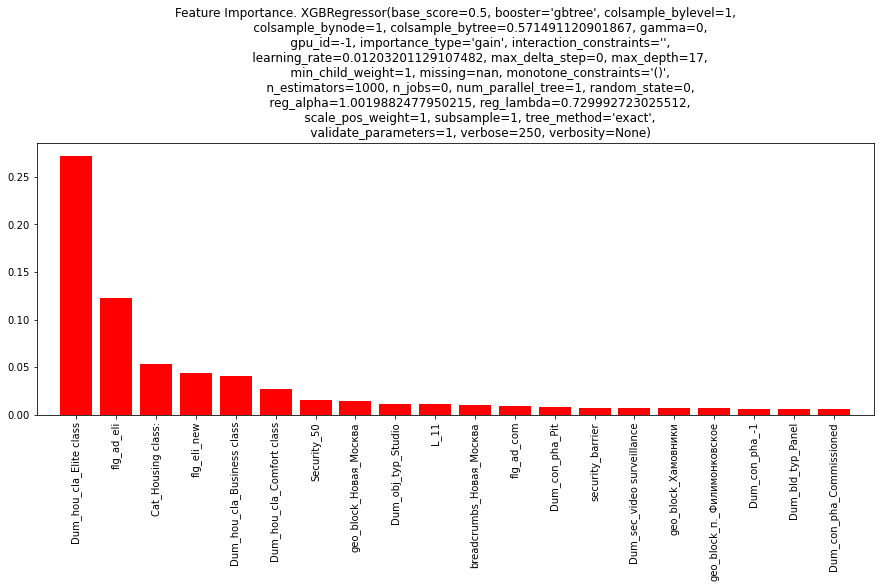

In [15]:
import lightgbm as lgb
import catboost as ctb

black_list = ['price','price_log','id']
feats = train.select_dtypes(exclude=[object, 'datetime' ]).columns
feats = [feat for feat in feats if feat not in black_list] 

def get_models():
    return [
        ('xbg1', xgb.XGBRegressor(n_estimators=1000, 
                                  max_depth=17, 
                                  learning_rate=0.01203201129107482, 
                                  colsample_bytree= 0.571491120901867, 
                                  reg_alpha=1.0019882477950215,
                                  reg_lambda=0.729992723025512,
                                  verbose=250)),
        #('ctb1', ctb.CatBoostRegressor( n_estimators = 1000, depth = 11, learning_rate=0.03, verbose=50)),
        #('lgb1', lgb.LGBMRegressor(n_estimators=1000, max_depth=11, learning_rate=0.03, verbose=50)),
        #('xbg2', xgb.XGBRegressor(n_estimators=1000, max_depth=12, learning_rate=0.15, verbose=50)),
        #('ctb2', ctb.CatBoostRegressor( n_estimators = 1000, depth = 12, learning_rate=0.15, verbose=50)),
        #('lgb2', lgb.LGBMRegressor(n_estimators=1000, max_depth=12, learning_rate=0.15, verbose=50)),
       
    ]

run(train, plot_lc=False, plot_feature_importances=True, target_log=True,
    use_black_list = False,
    use_feat_list = True,
    black_list=black_list,
    feats_list=feats
      )

**Hyperopt**

- maaaaaaaany iterations of this were calculated using different fixed parameters: `n_estimators (1000, 200, 100)`, `learning_rate (0.2)` etc
- sometimes calculated with selected features list, sometimes without; don't remember which one gave the 'winning' params - I was surely missing consistency here

In [7]:
##### HYPEROPT, FIXED N_ESTIMATORS (1000)

target_log = True

black_list = ['price','price_log','id','Commission agent:','Cat_Commission agent:','Security_85']
feats = train.select_dtypes(exclude=[object, 'datetime' ]).columns
feats = [feat for feat in feats if feat not in black_list] 
feats = ['Cat_Housing class:','Dum_hou_cla_Business class','Dum_obj_typ_Studio','geo_block_Новая_Москва','Cat_Construction phase:','Security_50','Cat_The view from the window:','Cat_Security:','views','days_since_added','breadcrumbs_МЦК_Шелепиха','Dum_bld_typ_Panel','Cat_Bathroom type:','breadcrumbs_МЦК_Лужники','breadcrumbs_МЦК_Деловой_центр','Dum_con_pha_Pit','day','Cat_Building type:','breadcrumbs_МЦК_Крымская','breadcrumbs_МЦК_Кутузовская','flg_apar_com','flg_ad_mor2','Dum_con_pha_-1','breadcrumbs_МЦК_Хорошёво','Dum_bat_typ_-1','flg_new_monbrick','month','MCC_flg_3','flg_mon_view','cnt_breadcrumbs','Cat_Garbage chute:','geo_block_г._Москва','other_than_MCC','breadcrumbs_МЦК_Шоссе_Энтузиастов','year','geo_block_ул_Сергея_Макеева','breadcrumbs_МЦК_Нижегородская','Cat_Object type:','geo_block_п._Филимонковское','Dum_ad_typ_secondary','geo_block_Хамовники','breadcrumbs_МЦК_Площадь_Гагарина','geo_block_Тверской','Dum_bat_typ_separate','breadcrumbs_МЦК_Верхние_Котлы','security_concierge','MCC_flg_2','Cat_Ad type:','security_barrier','Cat_Balcony type:','flg_flat_con','Dum_obj_typ_apartments','geo_block_Раменки','geo_block_д._Николо-Хованское','Dum_bld_typ_Brick','Dum_sec_closed area','geo_block_Дорогомилово','Cat_Free layout:','flg_flat_sep','breadcrumbs_МЦК_Стрешнево','flg_apar_bath','breadcrumbs_м._Пятницкое_шоссе','breadcrumbs_МЦК_Владыкино','breadcrumbs_МЦК_Панфиловская','flg_flat_mor','flg_ad_com','Cat_Elevator:','breadcrumbs_м._Саларьево','geo_block_Таганский','geo_block_г._Зеленоград','breadcrumbs_МЦК_Окружная','geo_block_Замоскворечье','Dum_view_street','geo_block_Выхино-Жулебино','geo_block_Пресненский','geo_block_Басманный','Dum_con_pha_Project','breadcrumbs_МЦК_Угрешская','flg_ad_bal','Dum_bal_typ_-1','Dum_con_pha_Building walls','breadcrumbs_МЦК_Балтийская','breadcrumbs_МЦК_Андроновка','Dum_con_pha_Commissioned','flg_elev_con','breadcrumbs_МЦК_Локомотив','breadcrumbs_МЦК_Дубровка','flg_yard_flat','Dum_bld_typ_Monolithic-brick','breadcrumbs_м._Ботанический_сад','breadcrumbs_МЦК_Ботанический_сад','flg_mon_ele','flg_apar_gar','geo_block_Люблино','Security_flg','geo_block_Крылатское','flg_ad_mor','Cat_Repair:','Cat_Phone:','geo_block_Хорошёво-Мнёвники']

X = train[feats].values
y = train["price"].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=3)
    
if target_log:
    y_train = np.log(y_train)
    
def objective(space):
    
    xgb_params = {
        'max_depth': int(space['max_depth']),
        'colsample_bytree': space['colsample_bytree'],
        'learning_rate': space['learning_rate'],
        #'subsample': space['subsample'],
        #'random_state': 1, #int(space['random_state']),
        #'min_child_weight': int(space['min_child_weight']),
        'reg_alpha': space['reg_alpha'],
        'reg_lambda': space['reg_lambda'],
        'n_estimators': 1000 #int(space['n_estimators']),
    }
    
    model = xgb.XGBRegressor(**xgb_params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    if target_log:
            y_pred = np.exp(y_pred)
            y_pred[y_pred < 0] = y_train.min() #czasem może być wartość ujemna
            
    score = mean_absolute_error(y_test, y_pred)
    
    return{'loss':score, 'status': STATUS_OK }
    
space ={
    'max_depth': hp.quniform ('x_max_depth', 2, 20, 1),
    'colsample_bytree': hp.uniform ('x_colsample_bytree', 0.5, 1.),
    'learning_rate': hp.uniform ('x_learning_rate', 0.01, 1),
    #'subsample': hp.uniform ('x_subsample', 0.7, 1.),
    #'random_state': hp.quniform ('x_random_state', 0, 10000, 50),
    #'min_child_weight': hp.quniform ('x_min_child_weight', 1, 10, 1),
    'reg_alpha': hp.loguniform ('x_reg_alpha', 0., 1.),
    'reg_lambda': hp.uniform ('x_reg_lambda', 0.7, 1.),
    #'n_estimators': hp.quniform ('x_n_estimators', 10, 100, 10),
}


trials = Trials()
best_params = fmin(fn=objective,
            space=space,
            algo=partial(tpe.suggest, n_startup_jobs=40),
            max_evals=200,
            trials=trials)

print("The best params: ", best_params)

 13%|█▎        | 26/200 [15:44<1:45:23, 36.34s/trial, best loss: 5.312285449876674]


KeyboardInterrupt: 

**Feature importance**

train model


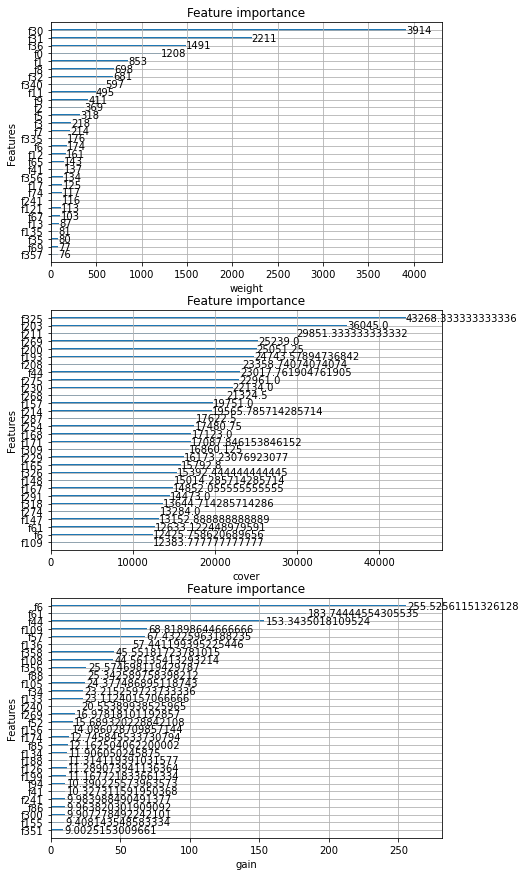

In [9]:
##### SAVE FEATURE IMPORTANCE
target_log = True

black_list = ['price','price_log','id']
feats = train.select_dtypes(exclude=[object, 'datetime' ]).columns
feats = [feat for feat in feats if feat not in black_list] 

X_train = train[feats].values
y_train = train["price"].values

#print(feats)
X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=1)

if target_log:
    y_train = np.log(y_train)
    
print("train model")
model = xgb.XGBRegressor(max_depth=10, n_estimators=70, learning_rate=0.1, random_state=4)
model.fit(X_train, y_train)

# NO IDEA why sometimes this gets plotted with variable names and sometimes with variable numbers (f1, f2, etc)
fig, ax = plt.subplots(3,1,figsize=(7,15))

nfeats = 30
importance_types = ['weight', 'cover', 'gain']

for i, imp_i in enumerate(importance_types):
    xgb.plot_importance(model, ax=ax[i], max_num_features=nfeats
                    , importance_type=imp_i
                    , xlabel=imp_i)

# save xgbfir file - but honestly I only used top 100 variables mentioned here to limit feature count in model testing

import xgbfir
xgbfir.saveXgbFI(model, OutputXlsxFile='bost_fi.xlsx')

**Winning submission and some notes**

the below code was rerun with test_size = 0.001 in X, X_val, y, y_val if I remember correctly ;)

I tested multiple approaches including Catboost, which gave some nice results, but I lost track in my chaos

Some examples of settings which yielded good results
- `xgb.XGBRegressor(max_depth=11, n_estimators=1000, learning_rate=0.03)` scored *5.01*

- `ctb.CatBoostRegressor( n_estimators = 5000, depth = 10, verbose=100, learning_rate=0.03)` scored *4.99* using the feats list shown below, this was submitted before new metro variables were added

- `xgb.XGBRegressor(
    n_estimators=200,
    colsample_bytree= 0.5542367557753002,
    learning_rate=0.09381859455829573,
    max_depth=13,
    reg_alpha= 1.3012597466433113,
    reg_lambda = 0.7290345117540642)` scored *4.92510*

**Many thanks** to slack community for some good ideas, such as Metro lines data and custom metric with which I got stuck until the last day

In [ ]:
feats = ['Cat_Housing class:','Dum_hou_cla_Business class','Dum_obj_typ_Studio','geo_block_Новая_Москва','Cat_Construction phase:','Security_50','Cat_The view from the window:','Cat_Security:','views','days_since_added','breadcrumbs_МЦК_Шелепиха','Dum_bld_typ_Panel','Cat_Bathroom type:','breadcrumbs_МЦК_Лужники','breadcrumbs_МЦК_Деловой_центр','Dum_con_pha_Pit','day','Cat_Building type:','breadcrumbs_МЦК_Крымская','breadcrumbs_МЦК_Кутузовская','flg_apar_com','flg_ad_mor2','Dum_con_pha_-1','breadcrumbs_МЦК_Хорошёво','Dum_bat_typ_-1','flg_new_monbrick','month','MCC_flg_3','flg_mon_view','cnt_breadcrumbs','Cat_Garbage chute:','geo_block_г._Москва','other_than_MCC','breadcrumbs_МЦК_Шоссе_Энтузиастов','year','geo_block_ул_Сергея_Макеева','breadcrumbs_МЦК_Нижегородская','Cat_Object type:','geo_block_п._Филимонковское','Dum_ad_typ_secondary','geo_block_Хамовники','breadcrumbs_МЦК_Площадь_Гагарина','geo_block_Тверской','Dum_bat_typ_separate','breadcrumbs_МЦК_Верхние_Котлы','security_concierge','MCC_flg_2','Cat_Ad type:','security_barrier','Cat_Balcony type:','flg_flat_con','Dum_obj_typ_apartments','geo_block_Раменки','geo_block_д._Николо-Хованское','Dum_bld_typ_Brick','Dum_sec_closed area','geo_block_Дорогомилово','Cat_Free layout:','flg_flat_sep','breadcrumbs_МЦК_Стрешнево','flg_apar_bath','breadcrumbs_м._Пятницкое_шоссе','breadcrumbs_МЦК_Владыкино','breadcrumbs_МЦК_Панфиловская','flg_flat_mor','flg_ad_com','Cat_Elevator:','breadcrumbs_м._Саларьево','geo_block_Таганский','geo_block_г._Зеленоград','breadcrumbs_МЦК_Окружная','geo_block_Замоскворечье','Dum_view_street','geo_block_Выхино-Жулебино','geo_block_Пресненский','geo_block_Басманный','Dum_con_pha_Project','breadcrumbs_МЦК_Угрешская','flg_ad_bal','Dum_bal_typ_-1','Dum_con_pha_Building walls','breadcrumbs_МЦК_Балтийская','breadcrumbs_МЦК_Андроновка','Dum_con_pha_Commissioned','flg_elev_con','breadcrumbs_МЦК_Локомотив','breadcrumbs_МЦК_Дубровка','flg_yard_flat','Dum_bld_typ_Monolithic-brick','breadcrumbs_м._Ботанический_сад','breadcrumbs_МЦК_Ботанический_сад','flg_mon_ele','flg_apar_gar','geo_block_Люблино','Security_flg','geo_block_Крылатское','flg_ad_mor','Cat_Repair:','Cat_Phone:','geo_block_Хорошёво-Мнёвники']

y_train [  3.42   4.83   7.17   9.91  15.41  48.   156.03]
[0]	validation_0-rmse:1.95164	validation_1-rmse:1.94155	validation_0-mae:15.58616	validation_1-mae:14.81737
[50]	validation_0-rmse:0.56503	validation_1-rmse:0.56553	validation_0-mae:8.56076	validation_1-mae:7.96405
[100]	validation_0-rmse:0.38293	validation_1-rmse:0.38772	validation_0-mae:6.23766	validation_1-mae:5.79559
[150]	validation_0-rmse:0.32136	validation_1-rmse:0.33023	validation_0-mae:5.35088	validation_1-mae:5.03351
[200]	validation_0-rmse:0.29598	validation_1-rmse:0.30843	validation_0-mae:4.96094	validation_1-mae:4.74602
[250]	validation_0-rmse:0.28388	validation_1-rmse:0.29906	validation_0-mae:4.76206	validation_1-mae:4.62630
[300]	validation_0-rmse:0.27708	validation_1-rmse:0.29446	validation_0-mae:4.64124	validation_1-mae:4.56632
[350]	validation_0-rmse:0.27277	validation_1-rmse:0.29212	validation_0-mae:4.55434	validation_1-mae:4.53662
[400]	validation_0-rmse:0.26930	validation_1-rmse:0.29039	validation_0-mae:4.4

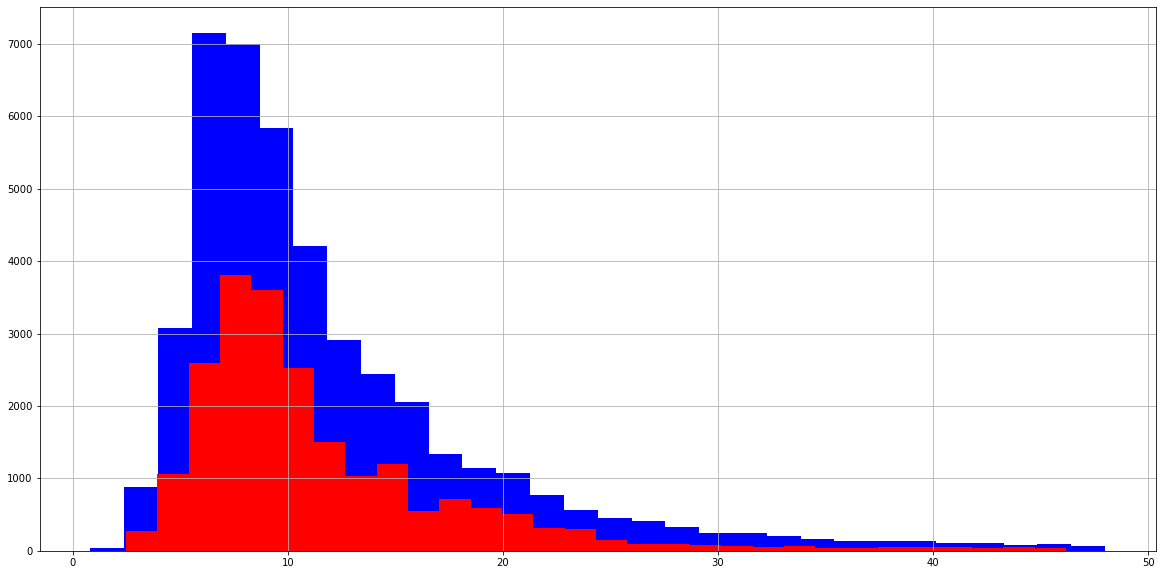

In [6]:
##### new validation method - from Vladimir's code

#validation score 30% - NEW METRIC: 4.944733137617609
# kaggle: 4.83899

def mae_log_eval(y_log_pred, dtrain):
    y_log_true = dtrain.get_label()
    
    shift = 10
    y_true = np.exp(y_log_true) - shift
    y_pred = np.exp(y_log_pred) - shift
    
    return 'mae', mean_absolute_error(y_true, y_pred)

def fair_obj(y_true, preds):
    labels = y_true
    x = (preds - labels)
    fair_constant = 0.5
    den = abs(x) + fair_constant
    
    grad = fair_constant * x / den
    hess = fair_constant * fair_constant / (den * den)
    
    return grad, hess

target_log = True

black_list = ['price','price_log','id','Commission agent:','Cat_Commission agent:','Security_85']
feats = train.select_dtypes(exclude=[object, 'datetime' ]).columns
feats = [feat for feat in feats if feat not in black_list] 

X_train = train[feats].values
y_train = train["price"].values
X_test = test[feats].values

print('y_train', np.round(np.percentile(y_train, [1,5,25,50,75,95,99]),2))

shift = 0

if target_log:
    y_train = np.log(y_train + shift)
    
# here my attempt at last final validation score of 10%: datasets X_val2 and y_val2

X, X_val, y, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=16)
X_val, X_val2, y_val, y_val2 = train_test_split(X_val, y_val, test_size=0.3, random_state=16) 

xgb_params = {'objective' : fair_obj,
              'n_estimators':1000, 
              'colsample_bytree' : 0.571491120901867,
              'learning_rate' : 0.01203201129107482, 
              'max_depth':17, 
              'reg_alpha':1.0019882477950215,
              'reg_lambda':0.729992723025512}

model = xgb.XGBRegressor(**xgb_params)

eval_set = [(X_train, y_train), (X_val, y_val)]

model.fit(X, y, \
         eval_metric = mae_log_eval,
         eval_set = eval_set, \
         verbose = 50)


print("predict - NEW METRIC")

y_pred_val = model.predict(X_val)
y_pred_val2 = model.predict(X_val2)
y_pred = model.predict(X_test)

print('pre np.exp y_train', np.round(np.percentile(y_train, [1,5,25,50,75,95,99]),2))
print('pre np.exp y_val', np.round(np.percentile(y_val, [1,5,25,50,75,95,99]),2))
print('pre np.exp y_pred_val', np.round(np.percentile(y_pred_val, [1,5,25,50,75,95,99]),2))
print('pre np.exp y_pred_val2', np.round(np.percentile(y_pred_val2, [1,5,25,50,75,95,99]),2))
print('pre np.exp y_pred', np.round(np.percentile(y_pred, [1,5,25,50,75,95,99]),2))

if target_log:
    y_train = np.exp(y_train) - shift
    y_train[y_train < 0] = y.min() #czasem może być wartość ujemna
    
    y_val = np.exp(y_val) - shift
    y_val[y_val < 0] = y.min() #czasem może być wartość ujemna
    
    y_val2 = np.exp(y_val2) - shift
    y_val2[y_val2 < 0] = y.min() #czasem może być wartość ujemna
    
    y_pred_val = np.exp(y_pred_val) - shift
    y_pred_val[y_pred_val < 0] = y.min() #czasem może być wartość ujemna
    
    y_pred_val2 = np.exp(y_pred_val2) - shift
    y_pred_val2[y_pred_val2 < 0] = y.min() #czasem może być wartość ujemna
    
    y_pred = np.exp(y_pred) - shift
    y_pred[y_pred < 0] = y.min() #czasem może być wartość ujemna
    
score_val = mean_absolute_error(y_val2, y_pred_val2)
print(f'validation score 30% - NEW METRIC: {score_val}')


print('post np.exp y_train', np.round(np.percentile(y_train, [1,5,25,50,75,95,99]),2))
print('post np.exp y_val', np.round(np.percentile(y_val, [1,5,25,50,75,95,99]),2))
print('post np.exp y_pred_val', np.round(np.percentile(y_pred_val, [1,5,25,50,75,95,99]),2))
print('post np.exp y_pred_val2', np.round(np.percentile(y_pred_val2, [1,5,25,50,75,95,99]),2))
print('post np.exp y_pred', np.round(np.percentile(y_pred, [1,5,25,50,75,95,99]),2))



print("save file")
test['price'] = y_pred
test[ ['id', 'price'] ].to_csv('output/newmetric_1_check.csv', index=False) 

plt.figure(figsize = (20,10))
train[ train.price < np.percentile( train.price, 95 ) ]['price'].hist(bins=30, color='blue')
test[ test.price < np.percentile( test.price, 95 ) ]['price'].hist(bins=30, color='red')
plt.show()
